In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(style='whitegrid', font_scale=0.9, rc={"lines.linewidth": 1.4,
                                           'lines.markersize': 1.6}, font="serif")

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

/Users/dylancromer/.venvs/maszcal/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [3]:
import numpy as np
import scipy.integrate
import scipy.special as special_funcs
import cubature
import maszcal.matter
from maszcal.cosmology import CosmoParams
from maszcal.mathutils import trapz_
import projector.mathutils as mathutils
import projector

In [4]:
help(mathutils.atleast_kd)

Help on function atleast_kd in module projector.mathutils:

atleast_kd(array, k, append_dims=True)



In [5]:
power = maszcal.matter.Power(CosmoParams())
zs = np.linspace(0, 1, 20)

In [6]:
ks_ = np.logspace(-4, 2, 100)
zs = np.linspace(0, 1, 10)

ps_interpolator_ = power.get_spectrum_interpolator(ks_, zs, is_nonlinear=True)
ps_interpolator_lin_ = power.get_spectrum_interpolator(ks_, zs, is_nonlinear=False)

In [24]:
def ps_interpolator(k):
    return ps_interpolator_(k, zs).T


def ps_interpolator_lin(k):
    return ps_interpolator_lin_(k, zs).T

In [108]:
def xi_integrand(ln_k, r):
    k = np.array([np.exp(ln_k)])
    power_spect = ps_interpolator(k)[None, :, :]
    k = k[None, :, None]
    r = r[:, None, None]
    return k * k**2 * power_spect * np.sinc(k * r) / (2 * np.pi**2)

In [109]:
xi_integrand(0.1, np.array([1])).shape

(1, 1, 10)

In [110]:
interp_rs = np.logspace(-6, 1, 200)
fine_rs = np.logspace(-6, 1, 400)

In [111]:
_xis = scipy.integrate.quad_vec(
        lambda ln_k: xi_integrand(ln_k, interp_rs),
        np.log(1e-5),
        np.log(100),
        limit=2000,
    ) 

In [112]:
xi_errs = _xis[1]
xis = _xis[0][:, 0, :]

In [113]:
xi_errs

0.00011577476503500184

In [114]:
from maszcal.interpolate import RbfInterpolator
from maszcal.interp_utils import cartesian_prod

In [115]:
params = cartesian_prod(np.log(interp_rs), zs)
interpolator = RbfInterpolator(params=params, func_vals=np.log(xis))
interpolator.process()

In [116]:
def xi_interp(rs, zs):
    ln_rs = np.log(rs).flatten()
    params = cartesian_prod(ln_rs, zs)
    return np.exp(interpolator.interp(params).flatten()).reshape(rs.shape + zs.shape)

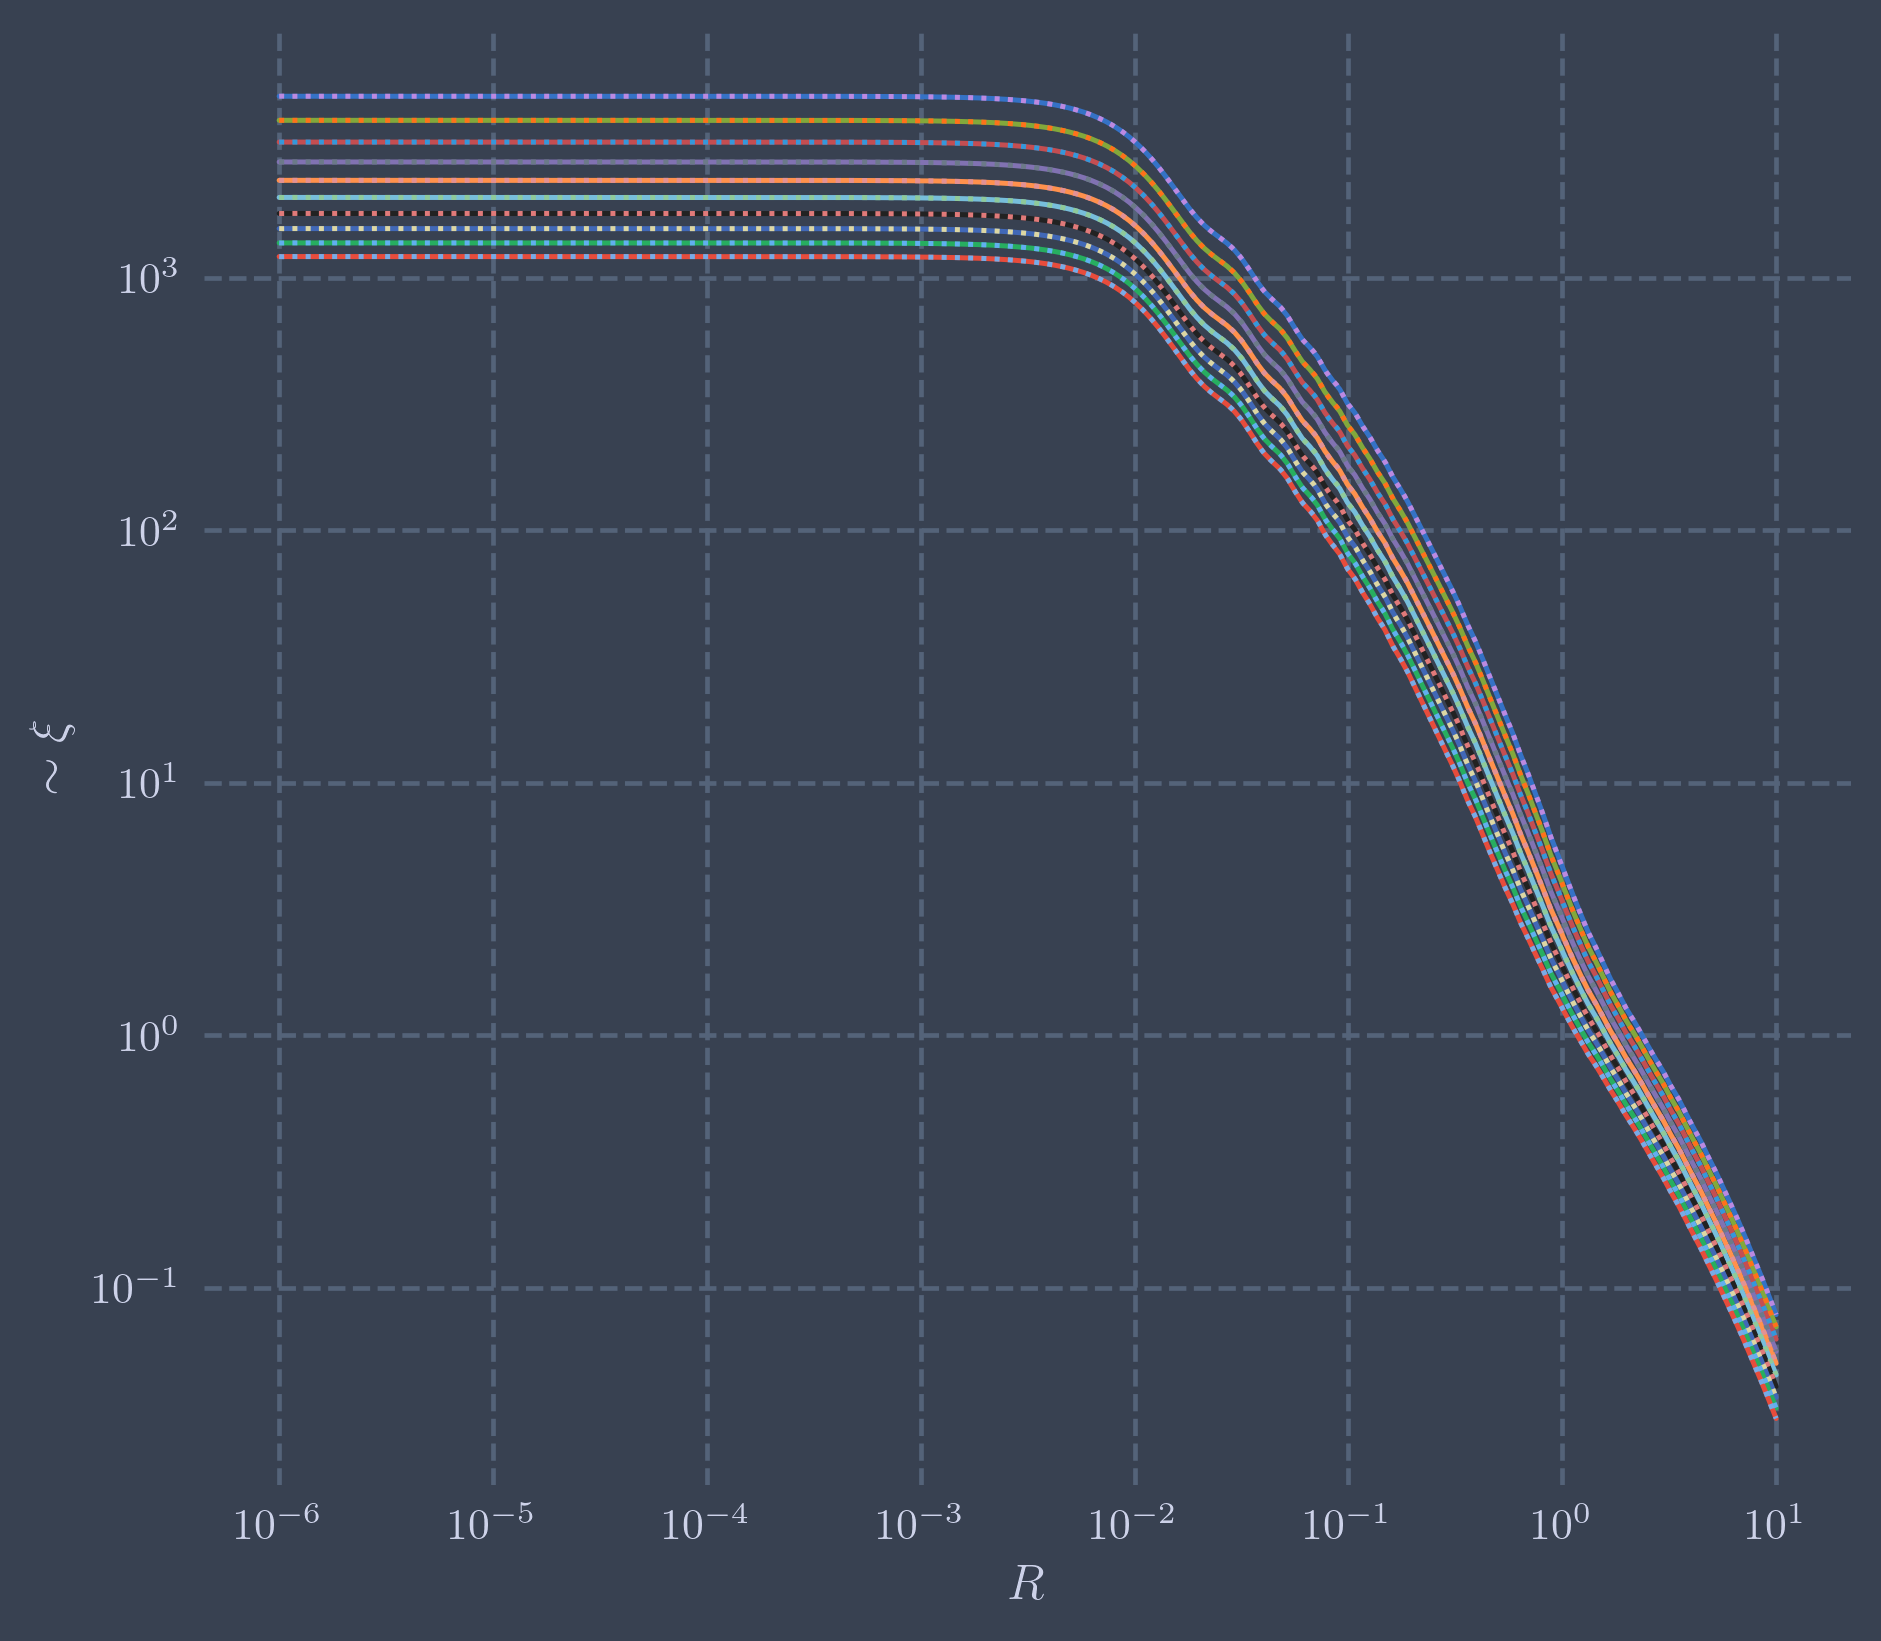

In [117]:
plt.plot(interp_rs, xis)
plt.plot(fine_rs, xi_interp(fine_rs, zs), linestyle=':')
#plt.plot(rs, two_halo_xi(rs), linestyle=':')
#plt.plot(rs, rs*esds_finest)
plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\sim \xi$')
plt.xlabel(r'$R$')

#plt.savefig('2halo.pdf')
pass

In [118]:
def density_func_(rs):
    return 1 + xi_interp(rs, zs)

In [119]:
rs = np.logspace(-1, 1, 100)
esds_ = projector.esd_quad(rs, density_func_)
#esds_finest = projector.esd(rs, density_func, num_points=1000)

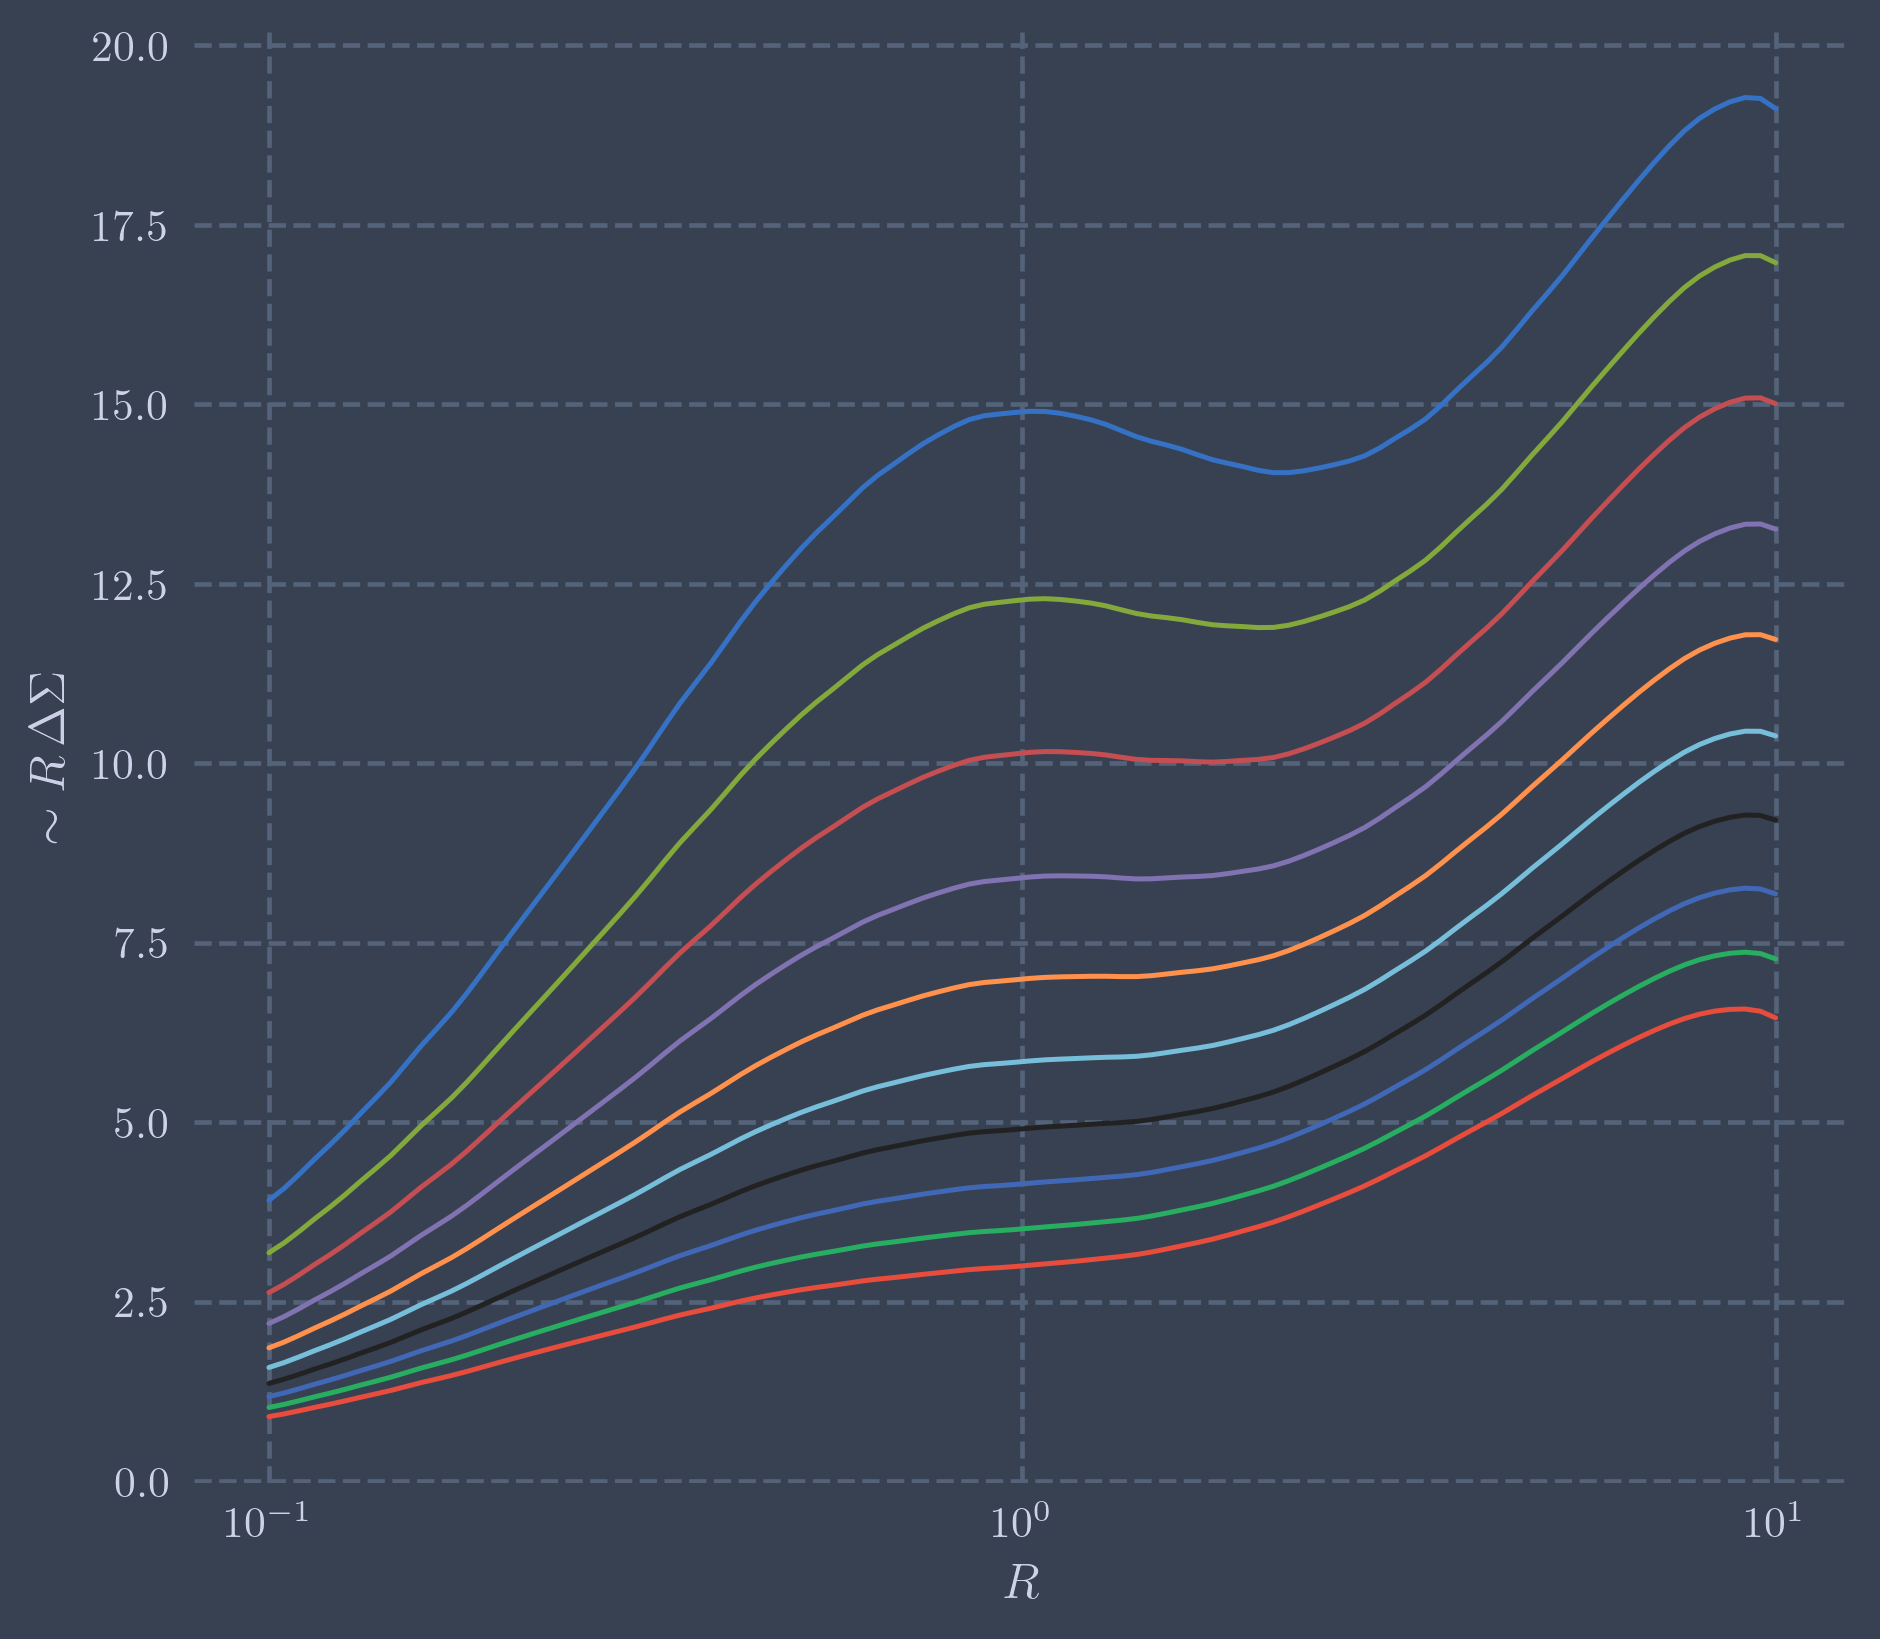

In [120]:
plt.plot(rs, rs[:, None]*esds_)
#plt.plot(rs, rs*esds_finest)
plt.xscale('log')
#plt.yscale('log')

plt.ylabel(r'$\sim R \, \Delta \Sigma$')
plt.xlabel(r'$R$')

#plt.savefig('2halo.pdf')
pass